# PhotochemPy Tutorial
This is a really short tutorial showing you how PhotochemPy works. 

First we will import the PhotochemPy module. 

In [1]:
# Do this one of the following ways!
from PhotochemPy import PhotochemPy # If installed with pip use this!

# If compiled in root directory with compile.sh, uncomment this
# (and comment out the other import command)
# import sys
# sys.path.append("..")
# from PhotochemPy import PhotochemPy

I'll also import some other standard packages (e.g. numpy).

In [2]:
import numpy as np
from matplotlib import pyplot as plt

## Setting up a problem
PhotochemPy requires a few input files when it is initialized.
- "species.dat": describes the species in the photochemical model, and their boundary conditions.
- "reactions.rx": describes the reactions in the atmosphere and their rates
- "planet.dat": describes the planet (surface gravity, etc.)
- "input_photochem.dat": sets several different options for the model.
- "atmosphere.txt": The initial atmospheric composition, temperature structure, eddy diffusion profile, and aersol parameters.
- "sun_flux.txt": The stellar flux

The best way to start is with one of the templates provided in the `input/templates` directory. Here, I'll use the `Archean+haze` template.

In [3]:
pc = PhotochemPy('../input/templates/Archean+haze/species.dat', \
                 '../input/templates/Archean+haze/reactions.rx', \
                 '../input/templates/Archean+haze/planet.dat', \
                 '../input/templates/Archean+haze/input_photchem.dat', \
                 '../input/templates/Archean+haze/atmosphere.txt', \
                 '../input/templates/Archean+haze/Sun_2.7Ga.txt')

## Integrating to photochemical equilibrium
The problem is now all set up! Now we can do a few different things. The thing that most people will want to do now in integrate the atmosphere forward in time to a state of photochemical equilibrium. We will do that with `pt.integrate()`

In [4]:
# here I set the number of steps the integrator will take
pc.integrate(nsteps = 1000)

Now we can output the solution. So for example, lets plot the CH$_4$ profile.

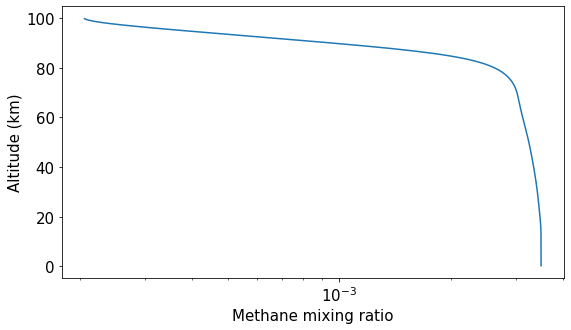

In [5]:
plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[9,5])
CH4 = pc.out_dict()['CH4'].copy()
ax.plot(CH4,pc.out_dict()['alt'])
ax.set_xscale('log')
ax.set_ylabel('Altitude (km)')
ax.set_xlabel('Methane mixing ratio')
plt.show()

We can also print the CH$_4$ surface flux required to sustain this atmospheric composition.

In [6]:
print('CH4 surface flux =','%.2e'%pc.surf_flux()['CH4'],'molecules/cm2/s')

CH4 surface flux = 6.07e+11 molecules/cm2/s


Currently, the boundary condition for CH$_4$ are set as a fixed mixing ratio. For this boundary condition, the model calculates the surface fluxed required to maintain the given mixing ratio. We can print the current mixing ratio of CH$_4$

In [7]:
ind = pc.ispec.index('CH4') # index of CH4 in the model
print('%.2e'%pc.photo.fixedmr[ind])

# quick note: `pt.photo` is a direct contact with all the data stored
# in the compile fortran module. There is a lot of stuff in there...
# to see all the things you can access run this command
# dir(pt.photo)

3.50e-03


Let's chance the mixing ratio to 1.0e-6, then re-integrate the equilibrium.

In [8]:
pc.set_mr('CH4',1.0e-6)
pc.integrate()

Now lets print out the new Methane flux, and compare the atmospheric methane profile to what it was before when the mixing ratio was set to 3.5e-3.

CH4 surface flux = 1.01e+09 molecules/cm2/s


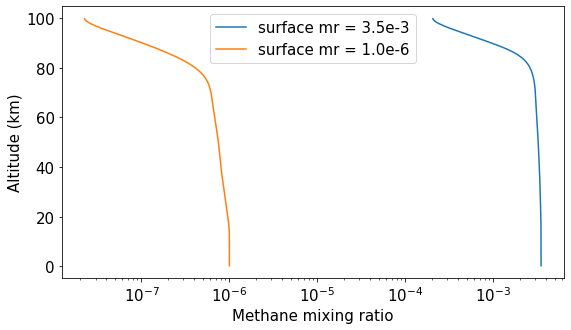

In [9]:
# print the surface flux
print('CH4 surface flux =','%.2e'%pc.surf_flux()['CH4'],'molecules/cm2/s')

# Plot
plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[9,5])
CH4_new = pc.out_dict()['CH4']
ax.plot(CH4,pc.out_dict()['alt'],label='surface mr = 3.5e-3')
ax.plot(CH4_new,pc.out_dict()['alt'],label='surface mr = 1.0e-6')
ax.set_xscale('log')
ax.set_ylabel('Altitude (km)')
ax.set_xlabel('Methane mixing ratio')
ax.legend()
plt.show()

It took a while to integrate to equilibrium after setting the CH$_4$ mixing ratio to 1e-6. This is because our initial conditions (the initial atmosphere in atmosphere.txt) are pretty "far away" from the solution. The following command (`pt.out2in()`) changes our initial conditions to the output the the past integration. This will allow much quicker convergence to the equilibrium state.

In [10]:
import time

start = time.time()
pc.integrate()
end = time.time()
print('%.2f'%(end-start),'seconds')

pc.out2in() # output to input!

start = time.time()
pc.integrate()
end = time.time()
print('%.2f'%(end-start),'seconds')

64.55 seconds
2.48 seconds


## Calculating many surface mixing ratios vs. surface fluxes
Often people want to know how much gas flux at the surface of a planet is required to sustain a particular molecule. Methane or Oxyen, for example, have large surface fluxes on the modern Earth due to life. This bit of code will calculate this relationship for one particular atmosphere.

In [11]:
CH4_mr = np.logspace(-6,-3,10)
CH4_flux = []

for mr in CH4_mr:
    pc.set_mr('CH4',mr)
    pc.integrate()
    pc.out2in() # really important to do this. It will speed up the computation
    CH4_flux.append(pc.surf_flux()['CH4'])
    

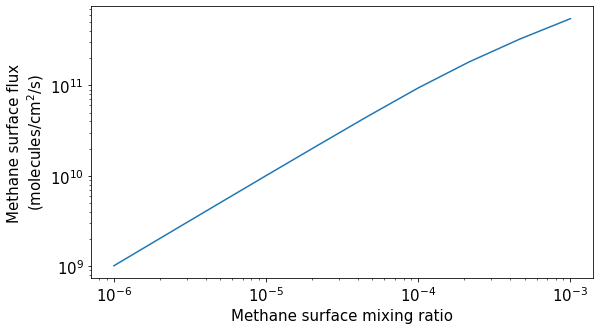

In [12]:
# Plot
fig,ax = plt.subplots(1,1,figsize=[9,5])

ax.plot(CH4_mr,CH4_flux)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Methane surface flux\n(molecules/cm$^2$/s)')
ax.set_xlabel('Methane surface mixing ratio')

plt.show()

## Returning the right-hand-side of the model equations
The photochemical model works by integrating a large system of ordinary differential equations (ODE). Each ODE has the form

$$\frac{df_i^j}{dt} = F(f_i^j)$$

Here, $f$ is the mixing ratio of species $i$ at layer $j$ in the atmosphere. $F(f_i^j)$ is the production or loss of that species from chemical reactions, diffusion in the atmosphere, escape to space, or a surface flux (volcano, or biology).

The Achean haze template has 61 species and 200 vertical layers. This means there are $61\times200 = 12200$ equations! Kinda a lot.

Here I'll show you how to return the value of all of these ODEs.

In [14]:
pc.reset() # resets everything by reading in original files (e.g. atmosphere.txt)
rhs = pc.right_hand_side(pc.photo.usol_init.flatten('F'))
# here I'll print the maximum value of the right-hand-side
print('%.2e'%np.max(np.abs(rhs)))
# The units of this are [change in mixing ratio/second]

1.63e-09


If we integrate to equilbirium, the maximum value of the right-hand side will be very small because the equations are in equilibrium.

In [15]:
pc.integrate()
pc.out2in()
rhs = pc.right_hand_side(pc.photo.usol_init.flatten('F'))
print('%.2e'%np.max(np.abs(rhs)))

1.89e-17


I can also return the jacobian of the right hand side. Its a banded matrix (zero everywhere but a band of some width along the diagonal). And so this function only prints the non-zero band.

In [16]:
jac = pc.jacobian(pc.photo.usol_init.flatten('F'))
print(jac.shape) # a big matrix!

(184, 12200)
